In [1]:
import pandas as pd

# Loading the photos file from the directory
df_photos = pd.read_csv("tmp/photos.tsv000", sep='\t')

# Select only the relevant columns
df_photos = df_photos[['photo_id', 'photo_image_url']]

# Display the DataFrame
df_photos

,photo_id,photo_image_url
0,bygTaBey1Xk,https://images.unsplash.com/uploads/1413387620...
1,gXSFnk2a9V4,https://images.unsplash.com/reserve/jEs6K0y1Sb...
2,grg6-DNJuaU,https://images.unsplash.com/uploads/1412192004...
3,sO42hhChB1c,https://images.unsplash.com/reserve/ijl3tATFRp...
4,tkk8_HakQ98,https://images.unsplash.com/reserve/6vaWXsQuSW...
...,...,...
24995,rZQq3bdOsJU,https://images.unsplash.com/photo-159220387694...
24996,swQ3JS8e-Fs,https://images.unsplash.com/photo-159186159766...
24997,pZroun8cH1w,https://images.unsplash.com/photo-159256175999...
24998,JqOvq9ypB4w,https://images.unsplash.com/photo-159191191322...


In [2]:
#needed
import pandas as pd
from PIL import Image
import requests
from tqdm.auto import tqdm
from transformers import CLIPProcessor, CLIPModel
import torch

# Load the CLIP model and processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

def extract_image_features(image):
    # Process the image using CLIP processor
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    return outputs.squeeze().tolist()

def create_embeddings(image=None, text=None):
    # Initialize embeddings
    image_embeddings = None
    text_embeddings = None
    
    # Process the image if provided
    if image is not None:
        image_embeddings = extract_image_features(image)
        image_embeddings = torch.tensor(image_embeddings)
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    # Process the text if provided
    if text is not None:
        text_inputs = processor(text=[text], return_tensors="pt", padding=True)
        with torch.no_grad():
            text_outputs = model.get_text_features(**text_inputs)
            text_embeddings = text_outputs / text_outputs.norm(dim=-1, keepdim=True)
            text_embeddings = text_embeddings.squeeze(0).tolist()

    # Combine the embeddings if both image and text are provided, and normalize
    if image_embeddings is not None and text_embeddings is not None:
        combined_embeddings = (image_embeddings + torch.tensor(text_embeddings)) / 2
        combined_embeddings = combined_embeddings / combined_embeddings.norm(dim=-1, keepdim=True)
        return combined_embeddings.tolist()

    # Return only image or text embeddings if one of them is provided
    return image_embeddings.tolist() if text_embeddings is None else text_embeddings

# Import pandas and load data
#df_images = pd.read_csv("tmp/photos.tsv000", sep='\t', header=0)

# Get the first 1000 images
photo_ids = df_photos['photo_id'][:1000]
df_photos = df_photos.loc[photo_ids.index, ['photo_id', 'photo_image_url']]

# Create a session to make HTTP requests
session = requests.Session()

# Define the function to download and get embeddings
def process_image(url):
    try:
        # Make a GET request to download the image
        response = session.get(url, stream=True)
        response.raise_for_status()
        image = Image.open(response.raw)
        # Get the embeddings and return
        return create_embeddings(image)
    except requests.RequestException:
        return None

# Construct a URL to download the image with a smaller size
df_photos['photo_image_url'] = df_photos['photo_image_url'].apply(lambda x: x + "?q=75&fm=jpg&w=200&fit=max")

# Pass the images one by one to the 'process_image' and save the embeddings to the newly created column 'photo_embed'
df_photos['photo_embed'] = [process_image(url) for url in tqdm(df_photos['photo_image_url'], total=len(df_photos))]

# Remove rows where image processing failed
df_photos.dropna(subset=['photo_embed'], inplace=True)

# Reset the index and rename the 'id' column to 'index'
df_photos = df_photos[df_photos['photo_id'].isin(photo_ids)].reset_index().rename(columns={'index': 'id'})

# Close the session
session.close()

C:\Users\tohfa\anaconda3\envs\Photo_Classifier\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
C:\Users\tohfa\anaconda3\envs\Photo_Classifier\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
df_photos

,id,photo_id,photo_image_url,photo_embed
0,0,bygTaBey1Xk,https://images.unsplash.com/uploads/1413387620...,"[-0.0027987370267510414, -0.011908568441867828..."
1,1,gXSFnk2a9V4,https://images.unsplash.com/reserve/jEs6K0y1Sb...,"[0.0021077392157167196, 0.0077454699203372, -0..."
2,2,grg6-DNJuaU,https://images.unsplash.com/uploads/1412192004...,"[0.011192524805665016, 0.025637801736593246, 0..."
3,3,sO42hhChB1c,https://images.unsplash.com/reserve/ijl3tATFRp...,"[-0.0005778892082162201, 0.009897821582853794,..."
4,4,tkk8_HakQ98,https://images.unsplash.com/reserve/6vaWXsQuSW...,"[-0.04457341134548187, -0.023003412410616875, ..."
...,...,...,...,...
995,995,7wmi235GscY,https://images.unsplash.com/photo-147041800180...,"[-0.04344752058386803, 0.04786011204123497, 0...."
996,996,kcolRj9wnec,https://images.unsplash.com/photo-147187382162...,"[0.003298654220998287, 0.0018007252365350723, ..."
997,997,34pAD9-7Rb8,https://images.unsplash.com/photo-147016666846...,"[0.007706461474299431, 0.006221169140189886, 0..."
998,998,itdkHUjTuIY,https://images.unsplash.com/photo-147470434644...,"[-0.02490030601620674, 0.045003361999988556, 0..."


C:\Users\tohfa\anaconda3\envs\Photo_Classifier\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


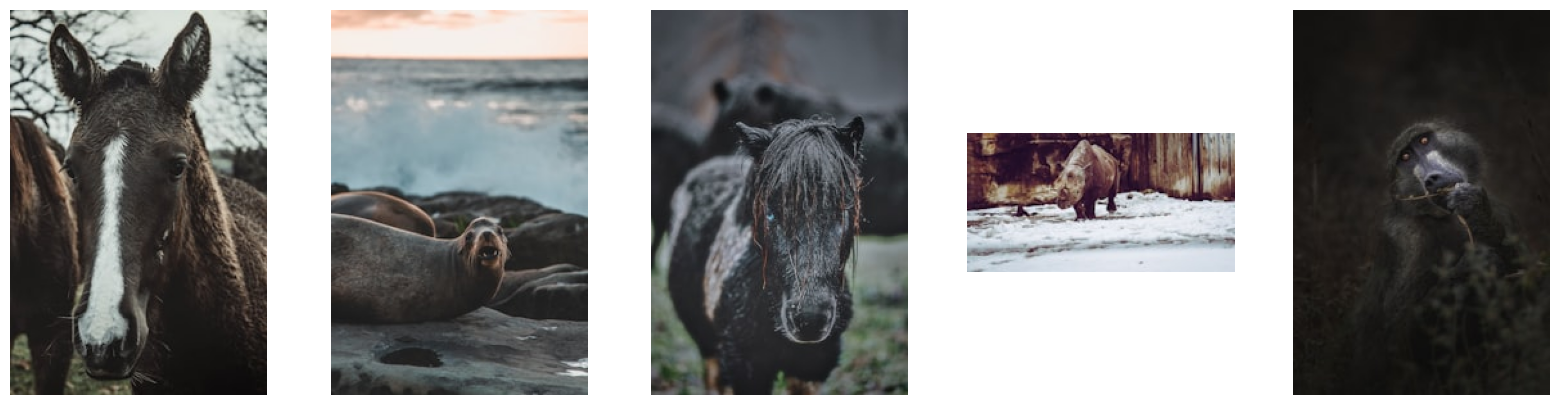

In [4]:
#needed
import torch
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load your dataset
#df = pd.read_csv('ImageToText.csv')  # Replace with your actual CSV file path

# Assuming your CSV has columns 'imageurl' and 'embeddings'
image_urls = df_photos['photo_image_url'].tolist()

# Load the embeddings directly, assuming they are in a compatible format
embeddings = torch.tensor(df_photos['photo_embed'].tolist())  # Adjust based on your actual format

# Function to search for relevant images given a prompt
def search_images(prompt, image_urls, embeddings, top_k=5):
    # Preprocess the prompt to create embeddings
    inputs = processor(text=[prompt], return_tensors="pt", padding=True)
    prompt_features = model.get_text_features(**inputs)
    
    # Compute cosine similarity between the prompt and precomputed image embeddings
    similarities = torch.nn.functional.cosine_similarity(prompt_features, embeddings)
    
    # Get the top k most similar images
    top_k_indices = similarities.topk(k=top_k).indices
    
    # Retrieve the image URLs and their similarity scores
    results = [(image_urls[idx], similarities[idx].item()) for idx in top_k_indices]
    
    return results

# Example usage
prompt = "Pictures of animals"
results = search_images(prompt, image_urls, embeddings, top_k=5)

# Display the results
fig, axes = plt.subplots(1, len(results), figsize=(20, 5))
for ax, (image_url, score) in zip(axes, results):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    ax.imshow(image)
    ax.axis('off')
    

plt.show()